<a href="https://colab.research.google.com/github/dahi84/BigData21/blob/branch_1/Kopie_von_template_retail_product_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Retail Product Categorisation**
Data Science project - SoSe 2021
---
Made by Daniel Hin

# Hypothesis

Hier Text: 

* Um was es geht es
* welche Daten stehen zur Verfügung
* Was soll klassifiziert werden
* Anstatz beschreiben

### Importing the necessary libraries




In [ ]:
 #! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"dahi84","key":"da381b36edf08e4163bc76def47dca56"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! pip install --upgrade --force-reinstall --no-deps kaggle
! kaggle datasets list
! kaggle competitions download -c 'retail-products-classification'
! mkdir retail-products-classification
! unzip retail-products-classification.zip -d retail-products-classification &> /dev/null

     |████████████████████████████████| 58 kB 4.6 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.12-py3-none-any.whl size=73052 sha256=b592b757692668d73821353101ba45bc54abc50bd5bd63e0d7041a3ec2f3507c
  Stored in directory: /root/.cache/pip/wheels/62/d6/58/5853130f941e75b2177d281eb7e44b4a98ed46dd155f556dc5
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              234KB  2021-07-24 09:20:05     

In [ ]:
!pip install keras_metrics
from tensorflow.keras.layers import Input
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from tensorflow.keras.applications.mobilenet import MobileNet
import nltk
from nltk.tokenize import word_tokenize
import gensim
import pandas as pd
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_english=set(stopwords.words('english'))
from gensim.models.wrappers import FastText
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
#import cv2
from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
from tensorflow.compat.v1.keras.initializers import Constant
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_metrics
from keras.preprocessing.image import load_img, img_to_array
from tabulate import tabulate
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Data Collection

Read the train.csv file: 

In [ ]:
data = pd.read_csv('retail-products-classification/train.csv')

Preperation to download the images for the train dataset: 




In [ ]:
train_images_path = 'retail-products-classification/train/train'
files = os.listdir(train_images_path)
img_list = []
for f in files:
  img_list.append(load_img(os.path.join(train_images_path,f), grayscale=False, color_mode='rgb', target_size=(80,80)))

In [ ]:
def create_training_data(img):
    image = load_img(os.path.join(train_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

#**1. Exploratory Data Analytics**


###1.1 Visualization and analysis of the text-based data set



In [ ]:
# definition of the 21 diffrent categories:
CATEGORIES = ['Electronics', 'Sports & Outdoors',
       'Cell Phones & Accessories', 'Automotive', 'Toys & Games',
       'Tools & Home Improvement', 'Health & Personal Care', 'Beauty',
       'Grocery & Gourmet Food', 'Office Products',
       'Arts, Crafts & Sewing', 'Pet Supplies', 'Patio, Lawn & Garden',
       'Clothing, Shoes & Jewelry', 'Baby',
       'Musical Instruments', 'Industrial & Scientific', 'Baby Products',
       'Appliances', 'All Beauty', 'All Electronics']
NUM_LABELS = len(CATEGORIES) # 21

21


In [ ]:
#pid = list(data['ImgId'])
#descriptions = list(data['description'])
data.head()

,ImgId,title,description,categories
0,B000HYL1V6,TUNGSTEN SOLDER PICK WITH HANDLE,Solder Pick for picking up molten solder when ...,"Arts, Crafts & Sewing"
1,B00006HXWY,Write Right 98167 Screen Protector for Sony T615C,We all screen. And we all need to protect thos...,Cell Phones & Accessories
2,B000GAWSBS,Casio Mens DBC310-1 Databank 300 Digital Watch...,"Bringing you precision at a glance, the Casio ...","Clothing, Shoes & Jewelry"
3,B000040JOL,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Factory-Reconditioned DEWALT DW260KR Heavy-Dut...,Tools & Home Improvement
4,B00006IB78,Energizer 2 in 1 Light,This twoway light features a bright flashlight...,Health & Personal Care


Distribution of samples in each categories

In [ ]:
#data['categories'].value_counts().plot(kind='bar', figsize=(14, 5));
#print(data['categories'].value_counts())
#data['categories'].value_counts().to_frame()
print(tabulate(data['categories'].value_counts().to_frame(),headers=["categories", "Number of items"], tablefmt='fancy_grid'))

╒═══════════════════════════╤═══════════════════╕
│ categories                │   Number of items │
╞═══════════════════════════╪═══════════════════╡
│ Arts, Crafts & Sewing     │              2225 │
├───────────────────────────┼───────────────────┤
│ Beauty                    │              2202 │
├───────────────────────────┼───────────────────┤
│ Grocery & Gourmet Food    │              2201 │
├───────────────────────────┼───────────────────┤
│ Sports & Outdoors         │              2201 │
├───────────────────────────┼───────────────────┤
│ All Beauty                │              2200 │
├───────────────────────────┼───────────────────┤
│ Toys & Games              │              2200 │
├───────────────────────────┼───────────────────┤
│ Industrial & Scientific   │              2200 │
├───────────────────────────┼───────────────────┤
│ Clothing, Shoes & Jewelry │              2200 │
├───────────────────────────┼───────────────────┤
│ Baby Products             │              2200 │


**Note:** All categories have approximately the same number of articles

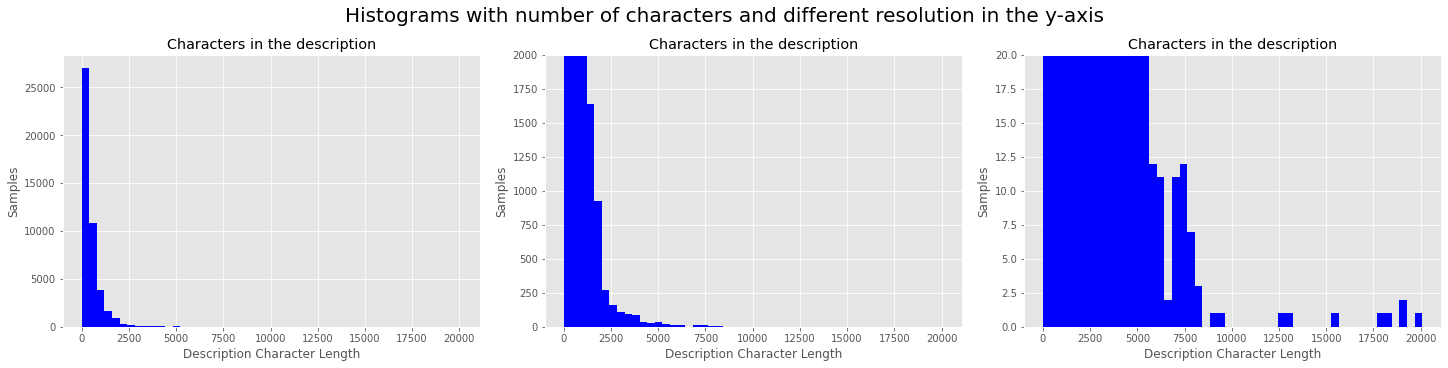

In [ ]:
character_len=data['description'].str.len()

fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(20,5))
fig.suptitle('Histograms with number of characters and different resolution in the y-axis', fontsize=20)

axes[1].set_ylim([0, 2000])
axes[2].set_ylim([0, 20])

for i in range(3):
  axes[i].hist(character_len, bins=50, color='blue')
  axes[i].set_ylabel('Samples')
  axes[i].set_xlabel('Description Character Length')
  axes[i].set_title('Characters in the description')

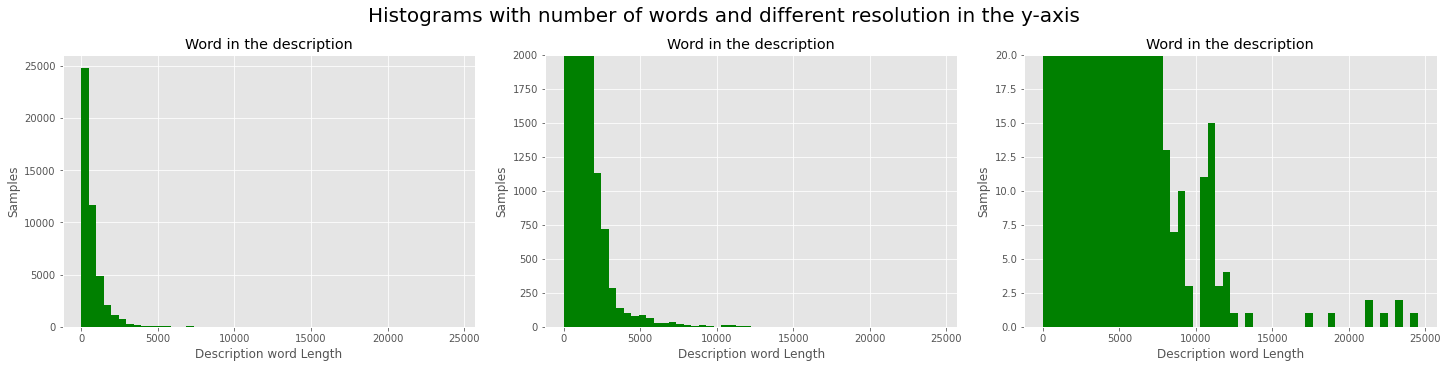

In [ ]:
word_len=data['description'].str.split().map(lambda x: len(str(x)))

fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(20,5))
fig.suptitle('Histograms with number of words and different resolution in the y-axis', fontsize=20)
axes[1].set_ylim([0, 2000])
axes[2].set_ylim([0, 20])

for i in range(3):
  axes[i].hist(word_len, bins=50, color='green')
  axes[i].set_ylabel('Samples')
  axes[i].set_xlabel('Description word Length')
  axes[i].set_title('Word in the description')

**Note:** There are a small number ouf samples with a very large description

In [ ]:
#Print the description of the item with the largest number of character
data['description'].iloc[word_len.argmax()]

'Turbo.264 HD Video Encoder &amp; AcceleratorConvert HD video to the universal H.264 formatThe Turbo.264 HD is a USB hardware device and accompanying Mac software that works together to dramatically accelerate the conversion of video to H.264 format.H.264 video is a universal format that can be played on iPod, iPhone, Apple TV, gaming consoles, YouTube, and much more.The Turbo.264 HD accepts nearly any video file and outputs high quality H.264 video, in formats up to full 1080P HD.[if gte mso 9]><xml> <w:WordDocument> <w:View>Normal</w:View> <w:Zoom>0</w:Zoom> <w:TrackMoves  /> <w:TrackFormatting  /> <w:PunctuationKerning  /> <w:ValidateAgainstSchemas  /> <w:SaveIfXMLInvalid>false</w:SaveIfXMLInvalid> <w:IgnoreMixedContent>false</w:IgnoreMixedContent> <w:AlwaysShowPlaceholderText>false</w:AlwaysShowPlaceholderText> <w:DoNotPromoteQF  /> <w:LidThemeOther>EN-US</w:LidThemeOther> <w:LidThemeAsian>X-NONE</w:LidThemeAsian> <w:LidThemeComplexScript>X-NONE</w:LidThemeComplexScript> <w:Compati

**Note:** There are a lot of words and characters which are not relevant for the description

Looking for titles and descriptions which are empty:

In [ ]:
#count the NaN values
print('Number of items without a description:',data['description'].isnull().sum())
print('Number of items without a title:',data['title'].isnull().sum())

Number of items without a description: 1042
Number of items without a title: 1


More detailed analysis of the items without description:

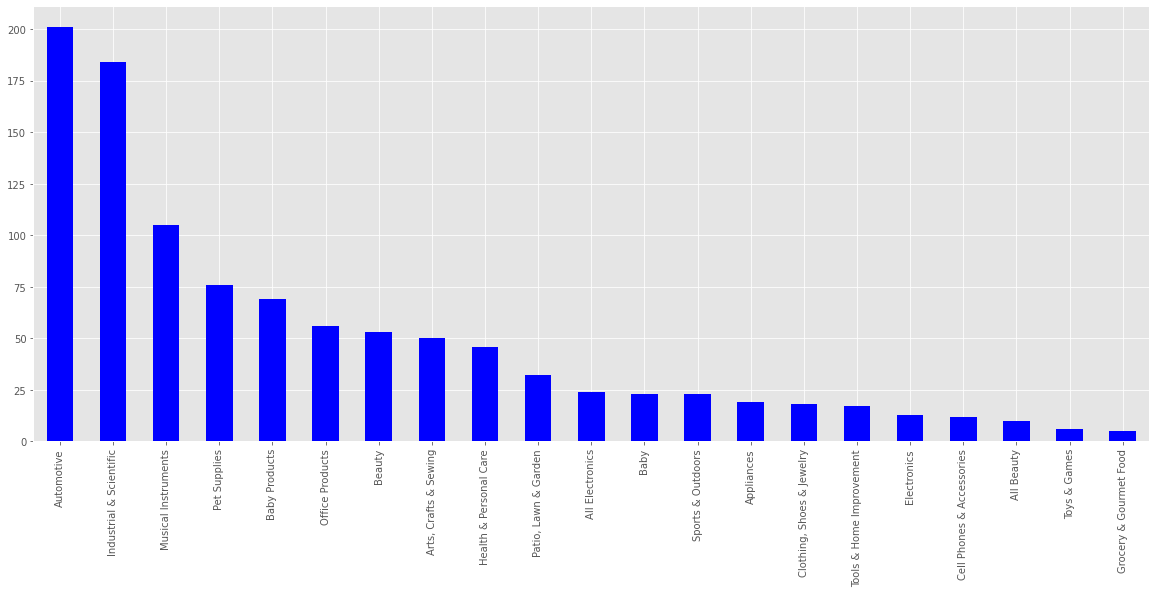

In [ ]:
d_NaN = data[data['description'].isnull()]
d_NaN['categories'].value_counts().plot(kind='bar',figsize=(20,8),color='blue')

**Note:** There are four categories with more than 75 items without a description.

*   Idea: Delete these items before the model is trained. It is only a small amount of data that is lost per category in relation to the total amount
*  Or concatenate the title column and the description column into one column






###1.2 Visualization of some image examples

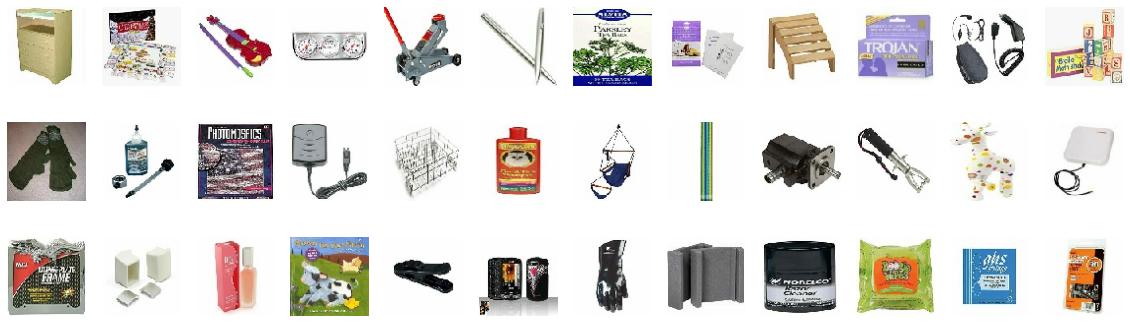

In [ ]:
rows = 3
columns = 12
stepsize = 999
j = 1

fig = plt.subplots(figsize=(20,6))

# eventuell noch die jeweilige Kategorie als title
for i in range(1,(rows*columns*stepsize),stepsize):
    plt.figsize=(19, 8)
    plt.subplot(rows,columns,j)
    plt.grid(False)
    plt.axis('off')
    plt.imshow(img_list[i])
    j += 1

###1.3 Text preprocessing

Clean the text data:

In [ ]:
def get_token(description):
        # split the description into tokens (words)
        tokens = set(gensim.utils.tokenize(description))
        # Avoid words does not have atleast 2 character 
        tokens = [i for i in tokens if(len(i) > 2)]
        # Remove stop words
        tokens = [s for s in tokens if s not in stop_english]
        # Remove alnum
        tokens = [c for c in tokens if c.isalnum()]
        return tokens

###1.4 Image preprocessing

Normalize the image:

In [ ]:
def preprocess_input(x, v2=True):
    x = x.astype('float32')
    x = x / 255.0
    x = x - 0.5
    x = x * 2.0
    return x

#**2. Model Building**

## Read Data
Read all the product images from the train folder and get corresponding description from the csv file. Data should labeled by its category. 

In [ ]:
# KEUPER ALTE VERSION
corpus = []
images = []
labels = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                token_list = get_token(str(title) + ' ' + str(description))
                corpus.append(token_list)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)

images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

In [ ]:
# NEUE IMPLEMENTIERUNG
corpus = []
images = []
labels = []
files = os.listdir(train_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_training_data(img)
    if img_array is not None:
        try:
            index = data[data['ImgId']==img_id].index.values[0]
            row = data.iloc[index , :]
            family = row[3]
            if family in CATEGORIES:
                description = row[2]
                title = row[1]
                images.append(img_array.astype('float32'))
                text_str = (str(title) + ' ' + str(description))
                #HIER EINE FUNKTION DEFINIEREN FÜR DATEN-VORVERARBEITUNG
                corpus.append(text_str)
                class_num = CATEGORIES.index(family)
                labels.append(class_num)
        except IndexError as error:
            print(error)
images = np.asarray(images)
labels = pd.get_dummies(labels).values
images = preprocess_input(images)

In [ ]:
for n in range(10):
  print(corpus[n])

Samsung Gravity Touch Professional Blue LED Car Charger for your Phone with digital rapid and slow charge features! Samsung Gravity Touch Phone Professional Blue LED Car Charger for your with digital rapid and slow charge features!
JP Lizzy Diana Tote Set, Green Built for function with just the right amount of pockets and space, JP Lizzy tote bags are designed with flair. Perfectly suited for toting your everyday gear, whether you're out with kids or out on the town.
Vetrin Canine Buffered Aspirin-325 mg, 100 count Vetrin Canine Buffered Aspirin-325 mg
Reclining Black Hydraulic Multi-Purpose Styling Chair Salon Equipment MP-30 BLK DIMENSIONS:Arm to Arm: 19.5" (Inside)Arm to Arm: 25" (Outside)Seat: 21" Width x 17.5" DepthBase: 23" DiameterBack Rest: 21" Depth x 21.5" HeightHeight Adjustment: 18"-24.5"Weight Capacity: Up to 300 lbs- All dimensions listed are approximations -
Pickapeppa Jerk Seasoning Pickapeppa speciall Jerk seasoning is an obsolute must for seasoning meat and fish dishe

##**2.1 Neural Network for text based prediction**

**Word2Vec implementation**

In [ ]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [ ]:
# integer encoding for the documents
vocab_size = 80000
#encoded_corpus
#for n in range(corpus):
encoded_corpus = [one_hot(i, vocab_size) for i in corpus]
print(encoded_corpus[1])

[70538, 79387, 23120, 11901, 25697, 61761, 13292, 23594, 76953, 65289, 66284, 30018, 64398, 9793, 70805, 68980, 33914, 79120, 70538, 79387, 11901, 56813, 65042, 34873, 65289, 13026, 3948, 22170, 23594, 11387, 32825, 19840, 57697, 11078, 74332, 45931, 65289, 19680, 30351, 45931, 57063, 30018, 22690]


In [ ]:
# padding text to a max length 40
padding_length = 80
padded_corpus = pad_sequences(encoded_corpus,maxlen=padding_length, padding='post')
print(padded_corpus[1])

[70538 79387 23120 11901 25697 61761 13292 23594 76953 65289 66284 30018
 64398  9793 70805 68980 33914 79120 70538 79387 11901 56813 65042 34873
 65289 13026  3948 22170 23594 11387 32825 19840 57697 11078 74332 45931
 65289 19680 30351 45931 57063 30018 22690     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [ ]:
# define the model
textmodel = Sequential()
textmodel.add(Embedding(vocab_size,8,input_length=padding_length))
textmodel.add(Flatten())
textmodel.add(Dense(NUM_LABELS,activation='sigmoid'))

In [ ]:
# compile the model
textmodel.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# generate and split data for fitting (80% train / 20% test)

p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]
text_train = padded_corpus[:p]
text_test = padded_corpus[p:]

print(padded_corpus.shape)
print(labels.shape)
print(text_train.shape)
print(label_train[1])

(42000, 80)
(42000, 21)
(33600, 80)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]


In [ ]:
# fitting the model
epochs=5
textmodel.fit(text_train,label_train,epochs=epochs, steps_per_epoch=len(image_train), verbose=1)

Epoch 1/5
33600/33600 [==============================] - 203s 6ms/step - loss: 0.1668 - accuracy: 0.3143
Epoch 2/5
33600/33600 [==============================] - 200s 6ms/step - loss: 0.0679 - accuracy: 0.7856
Epoch 3/5
33600/33600 [==============================] - 200s 6ms/step - loss: 0.0438 - accuracy: 0.8764
Epoch 4/5
33600/33600 [==============================] - 201s 6ms/step - loss: 0.0320 - accuracy: 0.9187
Epoch 5/5
17380/33600 [==============>...............] - ETA: 1:36 - loss: 0.0214 - accuracy: 0.9521

In [ ]:
# evaluation of the model
text_modelloss, text_modelaccuracy = textmodel.evaluate(text_train, label_train, verbose=0)
print('Accuracy train data: %f' % (text_modelaccuracy*100))

text_modelloss, text_modelaccuracy = textmodel.evaluate(text_test, label_test, verbose=0)
print('Accuracy test data: %f' % (text_modelaccuracy*100))

Accuracy train data: 98.145831
Accuracy test data: 68.607146


**BERT implementation**

In [ ]:
MAX_LEN=40
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)

tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')

word_index=tokenizer_obj.word_index

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,300))

print(sequences[3])
print(tweet_pad[3])
#print(embedding_matrix[1])
print(num_words)

[2163, 4071, 640, 97, 61, 53, 4763, 1205, 2163, 4071, 640, 97, 409, 61, 16, 12591, 54879, 94, 31, 69, 16, 28113, 54880, 94, 31, 69, 16, 5508, 54881, 94, 31, 69, 16, 5742, 54882, 94, 31, 69, 16, 15826, 326, 4763, 1205, 53]
[ 2163  4071   640    97    61    53  4763  1205  2163  4071   640    97
   409    61    16 12591 54879    94    31    69    16 28113 54880    94
    31    69    16  5508 54881    94    31    69    16  5742 54882    94
    31    69    16 15826]
107058


## FastText pretrained vectors
[Download](https://fasttext.cc/docs/en/crawl-vectors.html) and load FastText pretrained vectors. Otherwise use the gensim to load the fasttext model. These models were trained using CBOW with position-weights, in dimension 300, with character n-grams of length 5, a window of size 5 and 10 negatives. Then initilize the embedding matrix with fastText word vectors.

In [ ]:
import gensim.downloader as api
model_fasttext = api.load("fasttext-wiki-news-subwords-300")
known_words = []
unknown_words = []
for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    if word in model_fasttext:
        known_words.append(word)
        embedding_matrix[i] = model_fasttext.wv[word]
    else:
        unknown_words.append(word)
        

[==================================================] 100.0% 958.5/958.4MB downloaded


  0%|          | 0/72294 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  # This is added back by InteractiveShellApp.init_path()
100%|██████████| 72294/72294 [00:00<00:00, 215451.82it/s]


In [ ]:
print(len(unknown_words))
print(len(known_words))
del model_fasttext
print(embedding_matrix[1])

NameError: ignored

## Neural Network Model
Since our dataset contains both image and text, the model is capable to take both inputs together. For the image classification, we have used the MobileNet and LSTM network for the text classification. MobileNets are based on a streamlined architecture that uses depth-wise separable convolutions to build lightweight (17Mb) deep neural networks.
For the text classification, we have built a Keras sequential model which start with an embedding layer. The embedding layer holds individual vector for each word in the corpus. We have used fastText pre-trained English embedding to initialize each word by a 300-dimensional vector and loaded the pre-trained words embedding matrix into the embedding layer. After training the model, the words with semantically similar meaning often have similar vectors. Since the text classification model is a recurrent neural network, we added an LSTM layer followed by the embedding layer.

##**2.2 Neural Network for image based prediction**


In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
model = MobileNet(input_tensor=input_tensor, alpha=1.0,
                    include_top=False, weights=None)
output = tf.keras.layers.Reshape((4096,))(model.output)
output = tf.keras.layers.Dense(NUM_LABELS, activation='relu')(output)
model.summary()

In [ ]:
embedding_layer = tf.keras.layers.Embedding(num_words, 300, embeddings_initializer=Constant(embedding_matrix),
                                            input_length=MAX_LEN,trainable=False)
dropout = tf.keras.layers.SpatialDropout1D(0.2)
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2))
#lstm = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True))
lstm = tf.keras.layers.LSTM(64, dropout=0.2, recurrent_dropout=0.2)
dense = tf.keras.layers.Dense(200, activation='relu')
embedding_model = tf.keras.Sequential([
    embedding_layer,
    dropout,
    lstm,
    dense 
])
embedding_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 300)           21705300  
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 40, 300)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                93440     
_________________________________________________________________
dense_1 (Dense)              (None, 200)               13000     
Total params: 21,811,740
Trainable params: 106,440
Non-trainable params: 21,705,300
_________________________________________________________________


## Concatenate both models
Finally, we concatenate the output of both image and text classification model for interpretation and ultimate prediction. The functional API provided by Keras will help to build complex models with multiple output/input. We have used the Keras concatenate class to merge the result of both models. It takes a list of tensors, all are of the same shape as input and returns a single tensor which is the concatenation of all inputs. The concatenated output connects to the dense layer with softmax classifier. We have used the output layer to extract the embedding.

In [ ]:
# set the requiered settings for training
IMG_SIZE = (80,80)
INPUT_SHAPE = IMG_SIZE + (3,)
CALLBACK_PATIENCE = 10
BATCH_SIZE = 32
NUM_EPOCHS = 6
VALIDATION_SPLIT = .2
NUM_CLASSES = len(CATEGORIES)
L2_REGULARIZATION = 0.01

In [ ]:
merged = tf.keras.layers.Concatenate()([embedding_model.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, embedding_model.input], outputs=output_layer)

In [ ]:
# NEUE IMPLEMENTIERUNG
merged = tf.keras.layers.Concatenate()([textmodel.output, output])

normalize = tf.keras.layers.BatchNormalization()(merged)

final_dropout = tf.keras.layers.Dropout(0.2)(normalize)

dense_100 = tf.keras.layers.Dense(50, activation='relu')(final_dropout)

output_layer = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(dense_100)

final_model = tf.keras.Model(inputs=[model.input, textmodel.input], outputs=output_layer)

TypeError: ignored

In [ ]:
final_model.summary()

tf.keras.utils.plot_model(
    final_model, to_file='model.png', show_shapes=False, show_layer_names=True,
    rankdir='TB', expand_nested=False, dpi=96
)

## Split the data into 80% training and 20% test

In [ ]:
p = int((len(images)*80)/100)
image_train = images[:p]
image_test = images[p:]
label_train = labels[:p]
label_test = labels[p:]
text_train = tweet_pad[:p]
text_test = tweet_pad[p:]

In [ ]:
print('Shape of train',image_train.shape)
print("Shape of Validation ",image_test.shape)
print('Shape of train',label_train.shape)
print("Shape of Validation ",label_test.shape)
print("Shape of Text Train ",text_train.shape)

Shape of train (33600, 80, 80, 3)
Shape of Validation  (8400, 80, 80, 3)
Shape of train (33600, 21)
Shape of Validation  (8400, 21)
Shape of Text Train  (33600, 40)


## Data Augumentation

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
# Define the image transformations here
gen = ImageDataGenerator(horizontal_flip = True,
                         vertical_flip = True,
                         width_shift_range = 0.1,
                         height_shift_range = 0.1,
                         zoom_range = 0.1,
                         rotation_range = 40)

def gen_flow_for_two_inputs(X1, X2, y):
    genX1 = gen.flow(X1, y, batch_size=BATCH_SIZE, shuffle=False)
    genX2 = gen.flow(X1, X2, batch_size=BATCH_SIZE, shuffle=False)
    i = 0
    while True:
            X1i = genX1.next()
            X2i = genX2.next()
            #np.testing.assert_array_equal(X1i[0],X2i[0])
            yield [X1i[0], X2i[1]], X1i[1]
            #yield X2i[1]

# Finally create generator
gen_flow = gen_flow_for_two_inputs(image_train, text_train, label_train)

In [ ]:
regularization = tf.keras.regularizers.l2(L2_REGULARIZATION)

early_stop = EarlyStopping('val_loss', patience=CALLBACK_PATIENCE)
reduce_lr = ReduceLROnPlateau(
    'val_loss', factor=0.1, patience=int(CALLBACK_PATIENCE/4), verbose=1)
tensorboard = TensorBoard('./logs')
callbacks = [early_stop, reduce_lr, tensorboard]
#adam = tf.keras.optimizers.Adam(learning_rate=3e-4)
#optimizer = adam
final_model.compile(optimizer = 'adam',
              loss='categorical_crossentropy',
              #metrics=['accuracy'])
              metrics=['accuracy', keras_metrics.precision(), keras_metrics.recall()])

## Train the model
During training on a supervised machine learning prediction task, the parameters of the neural network - the weights- are the embeddings will modify to minimize the loss.

In [ ]:
tf.debugging.set_log_device_placement(True)

try:
  # Specify an invalid GPU device
  with tf.device('/GPU:0'):
    history = final_model.fit([image_train, text_train], label_train, batch_size=BATCH_SIZE,
                    epochs=NUM_EPOCHS, verbose=1, callbacks=callbacks, steps_per_epoch=len(image_train) // BATCH_SIZE, validation_data=([image_test,text_test], label_test))
except RuntimeError as e:
  print(e)

In [ ]:
! mkdir saved_model
final_model.save_weights("saved_model/weights_v1.h5")
#final_model.load_weights("static/weights.h5")

#**4. Validation**

In [ ]:
predictions = final_model.predict([image_test,text_test],batch_size=1,verbose = 2)
classes = np.argmax(predictions, axis = 1)
y_test = np.argmax(label_test, axis = 1)

ValueError: ignored

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
cm=confusion_matrix(y_test,classes)
accuracy = accuracy_score(y_test, classes)
print(accuracy)

0.7308333333333333
[[1.39741028e-08 4.90708881e-05 1.20270815e-05 ... 1.00857210e-06
  8.10666561e-01 1.51956338e-04]
 [3.08203939e-02 1.84443835e-02 5.79675689e-05 ... 6.05850108e-02
  1.66719547e-05 4.43411991e-03]
 [4.30641789e-03 2.26129771e-07 1.97797874e-07 ... 7.14363892e-08
  1.92697236e-08 3.77909484e-04]
 ...
 [3.96920996e-06 2.75402068e-04 2.49659297e-06 ... 1.36736533e-04
  2.15932205e-02 2.21955444e-04]
 [2.09022573e-06 6.95239229e-04 8.45880038e-07 ... 9.08890925e-03
  5.46847987e-05 1.86914578e-04]
 [9.35103890e-05 5.75468803e-05 4.25723847e-08 ... 1.47262483e-03
  3.56866451e-07 4.37486378e-05]]


Text(0.5, 114.0, 'Predicted label')

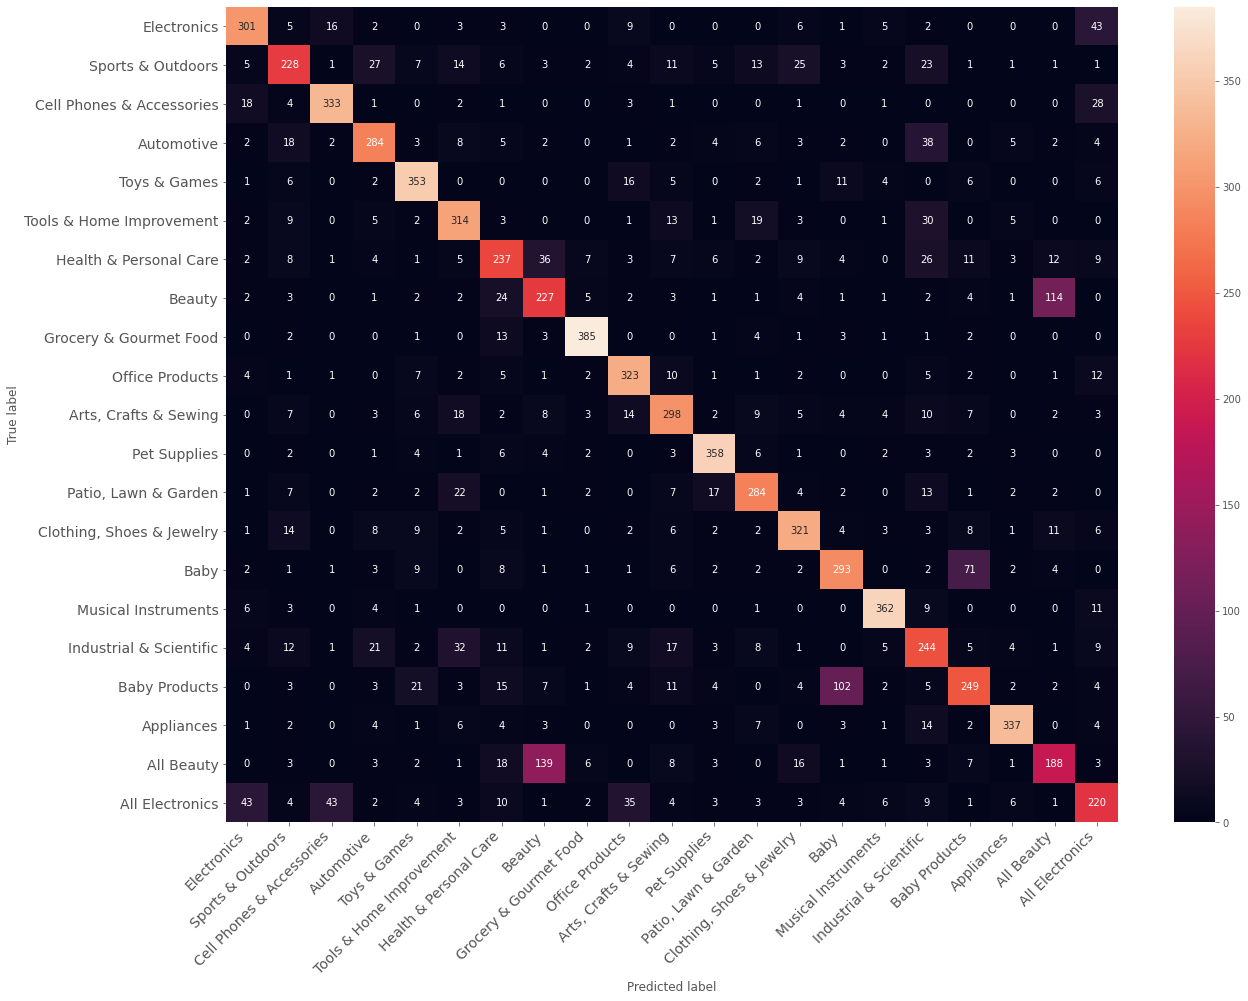

In [ ]:
import seaborn as sns
df_cm = pd.DataFrame(cm, index=CATEGORIES, columns=CATEGORIES)
fig = plt.figure(figsize=(20,15))
try:
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
except ValueError:
    raise ValueError("Confusion matrix values must be integers.")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=14)
plt.ylabel('True label')
plt.xlabel('Predicted label')

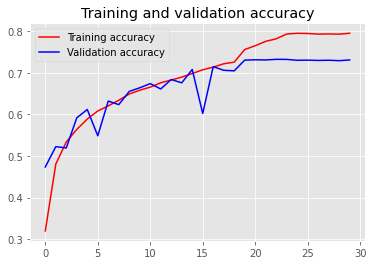

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

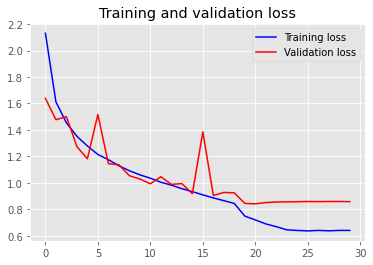

In [ ]:
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Extract and visualize embedding

In [ ]:
intermediate_layer_model = tf.keras.Model(inputs=final_model.input,
                                       outputs=final_model.layers[-1].output)
intermediate_output = intermediate_layer_model([image_train[:10000], text_train[:10000]])

y_train = np.argmax(label_train, axis = 1)
tsne_label = []
for i in range(10000):
    tsne_label.append(str(CATEGORIES[y_train[i]]))

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
from sklearn.manifold import TSNE
X = preprocessing.normalize(intermediate_output)
y = tsne_label
le = LabelEncoder()
y = le.fit_transform(y)

In [ ]:
tsne = TSNE(n_components=2, random_state=0)
target_ids = range(len(le.classes_))

X_2d = tsne.fit_transform(X)

plt.figure(figsize=(20, 20))
for i, label in zip(target_ids, le.classes_):
    plt.scatter(X_2d[y == i, 0], X_2d[y == i, 1], c=np.random.rand(3,), label=label)
plt.legend()
plt.show()

#**5. Final prediction on test data**

In [ ]:
# Read test data
data_test = pd.read_csv('retail-products-classification/test.csv')
data_test.head(10)

,ImgId,title,description
0,B0006IK25E,Jacquard Textile Paint 2.25 Oz Pink,Jacquard Textile Pink Color in 2.25 ounces can...
1,B000GBRO16,Fimo Soft Polymer Clay 2 Ounces-8020-33 Brilli...,Fimo Soft Polymer Clay is easier to use than b...
2,B000H6OZGW,Sculpey III 2 Oz. Polymer Clay: Pale Pistachio,Sculpey 3 Polymer Clay is America's original o...
3,B000BR28KC,Sennelier Soft Pastel Turquoise Green 724,Handmade since 1900 Sennelier extra-fine soft ...
4,B0006IK27M,Jacquard Textile Colors sapphire blue,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
5,B0000AZ6NS,"Sudbury Heavy Duty ELASTO Sealant, White, CART...","Elastomeric marine sealant. One part, fast ski..."
6,B0006IK268,Jacquard Textile Colors ruby red,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...
7,B000FNDZN6,Dylon Permanent Fabric Dye -Olive,Permanent Fabric Dye will not fade or wash awa...
8,B000GBO8UG,Fimo Soft Polymer Clay 2 Ounces-8020-70 Sahara,Fimo Soft Polymer Clay is easier to use than b...
9,B0006IK2FE,Jacquard Textile Colors yellow ochre,JACQUARD TEXTILE COLORS FABRIC PAINT - These e...


In [ ]:
del image_train
del image_test
del label_train
del label_test
del text_train
del text_test
del images
del data

In [ ]:
def get_token(description):
    token = list(gensim.utils.tokenize(description))
    token = [i for i in token if(len(i) > 2)]
    token = [s for s in token if s not in stop_english]
    return token

In [ ]:
test_images_path = 'retail-products-classification/test/test'
def create_test_data(img):
    image = load_img(os.path.join(test_images_path,img), grayscale=False, color_mode='rgb', target_size=(80,80))
    img_array = img_to_array(image)
    return img_array

In [ ]:
test_image_ids = []
test_corpus = []
test_images = []
files = os.listdir(test_images_path)
random.shuffle(files)
for img in files:
    img_id = img.split('.')[0]
    img_array = create_test_data(img)
    if img_array is not None:
        try:
            index = data_test[data_test['ImgId']==img_id].index.values[0]
            row = data_test.iloc[index , :]
            description = row[2]
            title = row[1]
            test_images.append(img_array.astype('float32'))
            test_corpus.append(get_token(str(title) + ' ' + str(description)))
            test_image_ids.append(img_id)
        except IndexError as error:
            print(error)

#tokenizer_obj=Tokenizer()
#tokenizer_obj.fit_on_texts(corpus)
#sequences=tokenizer_obj.texts_to_sequences(corpus)
#tokenizer_obj=Tokenizer()
sequences=tokenizer_obj.texts_to_sequences(test_corpus)
test_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
test_images = np.asarray(test_images)
test_images = preprocess_input(test_images)

##5.1 Make predictions on test data

In [ ]:
pred = final_model.predict([test_images, test_pad],batch_size=1,verbose = 2)
test_classes = np.argmax(pred, axis = 1)

6367/6367 - 79s


##5.2 Create submission file

In [ ]:
import csv
with open('submission.csv', mode='w') as metadata_file:
    metadata_writer = csv.writer(metadata_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    metadata_writer.writerow(['ImgId', 'category'])
    for i, val in enumerate(test_classes):
        metadata_writer.writerow([test_image_ids[i], test_classes[i]])